In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import pandas as pd

In [ ]:
#Utilities

def verify_str(value, valid):
  assert value in valid
  return valid.index(value)

splits = ['train', 'dev','test']
classes = ['gender', 'status']
class_names = ['noable','worrior','incarnation','commone']


def image_loader(path):
    path = os.path.join(root, 'images_256',path)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return np.asarray(img)
        

In [ ]:
import csv
def load_data(path, split, class_by):
  split = verify_str(split, splits)
  class_by = verify_str(class_by, classes)
  progress_bar = tqdm()
  labels = []
  images = []
  count=0
  with open(path) as csv_file:
      csv_reader = csv.reader(csv_file, delimiter=',')
      missed_images = []
      #skip header [image, gender,, status, set]
      next(csv_reader)
      for i, row in enumerate(csv_reader):

        #skip if entry belongs to a wrong split(train, dev, test)
        if row[3]!=splits[split]:
          continue
        #verify that image exists in a folder
        if os.path.exists(os.path.join(root, 'images_256', row[0]))==False:
          missed_images.append(row[0])
          continue

        labels.append(int(row[class_by+1]))
        images.append(image_loader(row[0]))

        progress_bar.update()
        if i % 1_000 == 0:
            progress_bar.set_postfix_str(s=str(len(labels)), refresh=True)
  progress_bar.close()
  print(f'Processed {len(images)} lines for {splits[split]}')
  if len(missed_images)>0:
    print(f'{len(missed_images)} images are missing: {missed_images}')
  return np.array(labels),np.array(images)   #.reshape(-1,1)   

In [ ]:
#Load dataset 4238 samples for train
import os
data_location = '/content/drive/MyDrive/Colab Notebooks/kaokore-master/kaokore'
root = os.path.expanduser(data_location)


train_label, train_images = load_data(os.path.join(root, 'labels.csv'),'train','status')
dev_label, dev_images = load_data(os.path.join(root, 'labels.csv'),'dev','status')
test_label, test_images = load_data(os.path.join(root, 'labels.csv'),'test','status')
print(train_label.shape)
print(train_images.shape)

0it [00:00, ?it/s]

Processed 4238 lines for train


0it [00:00, ?it/s]

Processed 533 lines for dev


0it [00:00, ?it/s]

Processed 527 lines for test
(4238,)
(4238, 256, 256, 3)


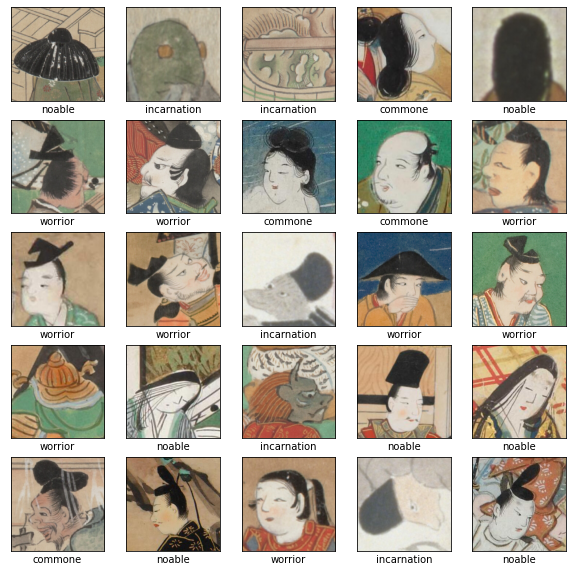

In [ ]:
#Visualise first 25 images with labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(0,25):

    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])

    plt.xlabel(class_names[int(train_label[i])])
plt.show()

In [ ]:
batch_size = 32
train_label_one_hot= np.array(pd.get_dummies(train_label))
dev_label_one_hot= np.array(pd.get_dummies(dev_label))
test_label_one_hot= np.array(pd.get_dummies(test_label))

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_label_one_hot)).batch(batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_images, dev_label_one_hot)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_label_one_hot)).batch(batch_size)

In [ ]:

AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.2, 0.2, fill_mode='reflect',
    interpolation='bilinear', seed=None, fill_value=0.0)
])

def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

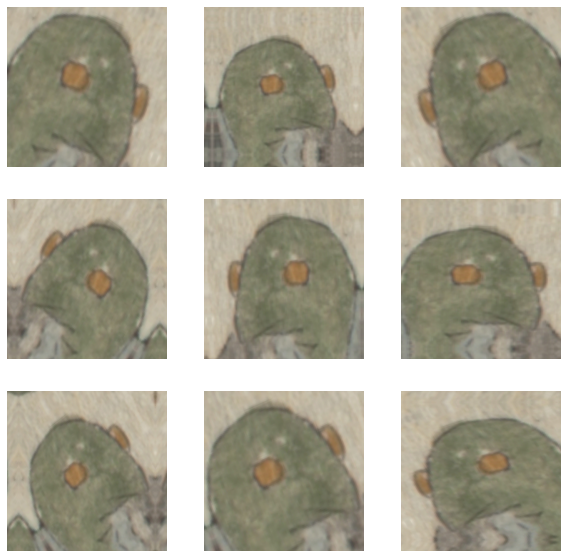

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # augmented_image =tf.expand_dims(first_image, 0)#
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
train_dataset = prepare(train_dataset, shuffle=True, augment=True)
# test_dataset = prepare(test_dataset)

In [ ]:
def MobileNetModelforStatus(image_shape):
    input_shape=image_shape
    base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # data preprocessing using the same weights the model was trained on
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 


    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
    # use a prediction layer with 4 neurons
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x) #softmax
    model = tf.keras.Model(inputs, outputs)
    
    return model


9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


133/133 [==============================] - 207s 2s/step - loss: 1.0007 - accuracy: 0.5975 - val_loss: 0.7338 - val_accuracy: 0.7167
Epoch 2/5
133/133 [==============================] - 209s 2s/step - loss: 0.7722 - accuracy: 0.6966 - val_loss: 0.6770 - val_accuracy: 0.7355
Epoch 3/5
133/133 [==============================] - 206s 2s/step - loss: 0.7125 - accuracy: 0.7180 - val_loss: 0.6579 - val_accuracy: 0.7392
Epoch 4/5
133/133 [==============================] - 206s 2s/step - loss: 0.6648 - accuracy: 0.7364 - val_loss: 0.6470 - val_accuracy: 0.7542
Epoch 5/5
133/133 [==============================] - 207s 2s/step - loss: 0.6564 - accuracy: 0.7454 - val_loss: 0.6425 - val_accuracy: 0.7542


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

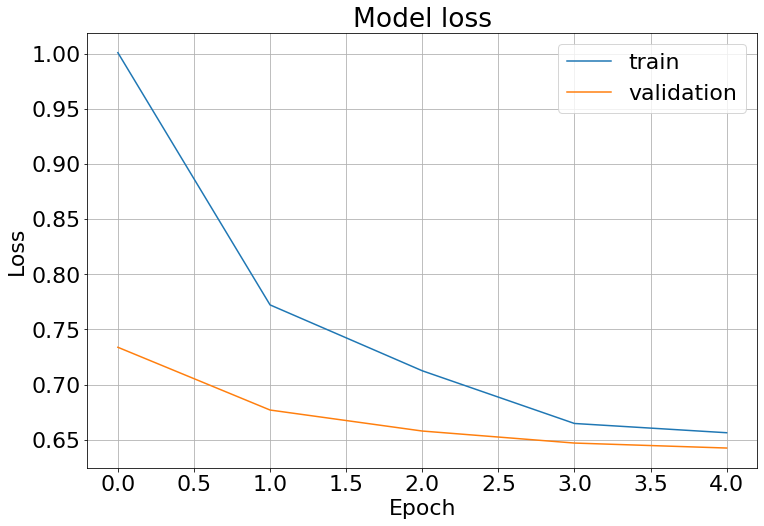

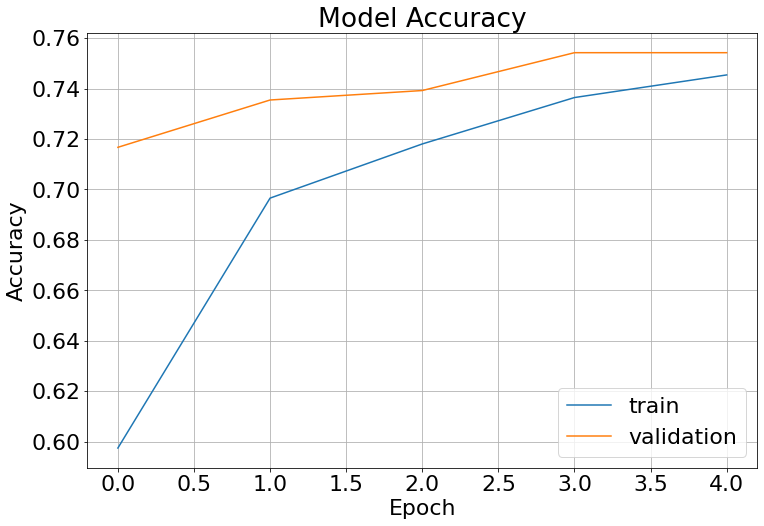

In [ ]:
#Mobile Net with learning rate 0.001 solver = Adam
image_shape = train_images[0].shape
plt.rcParams.update({'font.size': 22})
model_mobilenet = MobileNetModelforStatus(image_shape)
base_learning_rate = 0.001
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 5
history_mobilenet = model_mobilenet.fit(train_dataset, validation_data=dev_dataset, epochs=initial_epochs)
df_loss_acc = pd.DataFrame(history_mobilenet.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
# df_acc.grid(True)
df_loss.plot(title='Model loss',figsize=(12,8), grid=True).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8), grid=True).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
scores = model_mobilenet.evaluate(test_dataset, verbose=0)
print(scores)

[0.6090492010116577, 0.759013295173645]


Epoch 1/5
133/133 [==============================] - 147s 1s/step - loss: 1.0924 - accuracy: 0.6595 - val_loss: 0.7261 - val_accuracy: 0.7167
Epoch 2/5
133/133 [==============================] - 144s 1s/step - loss: 0.8060 - accuracy: 0.7414 - val_loss: 0.8655 - val_accuracy: 0.7148
Epoch 3/5
133/133 [==============================] - 144s 1s/step - loss: 0.8244 - accuracy: 0.7480 - val_loss: 0.9171 - val_accuracy: 0.7317
Epoch 4/5
133/133 [==============================] - 143s 1s/step - loss: 0.8990 - accuracy: 0.7489 - val_loss: 1.0621 - val_accuracy: 0.7448
Epoch 5/5
133/133 [==============================] - 143s 1s/step - loss: 0.8917 - accuracy: 0.7563 - val_loss: 0.9446 - val_accuracy: 0.7448


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

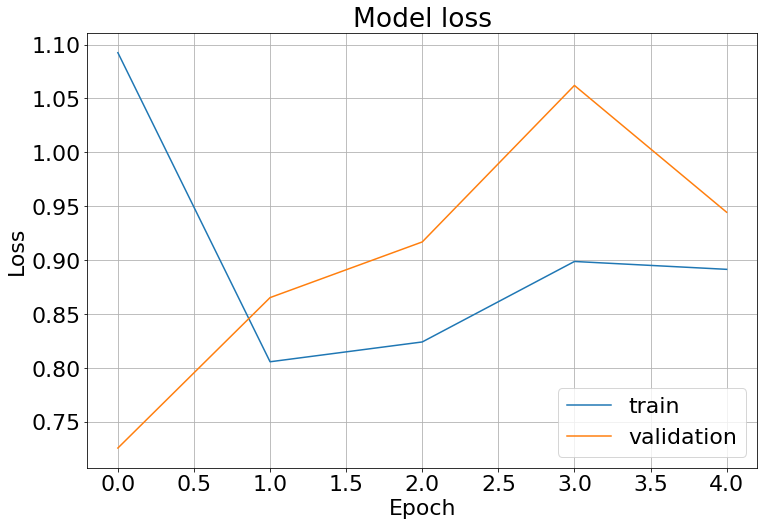

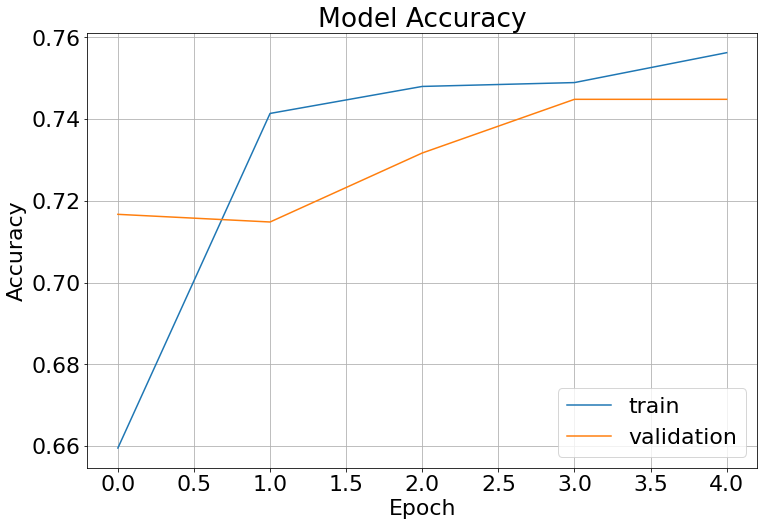

In [ ]:
#Mobile Net with learning rate 0.001 = > 0.01 solver = Adam
model_mobilenet = MobileNetModelforStatus(image_shape)
base_learning_rate = 0.01
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 5
history_mobilenet = model_mobilenet.fit(train_dataset, validation_data=dev_dataset, epochs=initial_epochs)
df_loss_acc = pd.DataFrame(history_mobilenet.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
# df_acc.grid(True)
df_loss.plot(title='Model loss',figsize=(12,8), grid=True).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8), grid=True).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
scores = model_mobilenet.evaluate(test_dataset, verbose=0)
print(scores)

[1.0482454299926758, 0.7020872831344604]


Epoch 1/5
133/133 [==============================] - 149s 1s/step - loss: 1.4154 - accuracy: 0.4101 - val_loss: 1.1856 - val_accuracy: 0.5084
Epoch 2/5
133/133 [==============================] - 146s 1s/step - loss: 1.2004 - accuracy: 0.4950 - val_loss: 1.0581 - val_accuracy: 0.5610
Epoch 3/5
133/133 [==============================] - 146s 1s/step - loss: 1.0791 - accuracy: 0.5644 - val_loss: 0.9806 - val_accuracy: 0.5891
Epoch 4/5
133/133 [==============================] - 146s 1s/step - loss: 1.0054 - accuracy: 0.5949 - val_loss: 0.9275 - val_accuracy: 0.6154
Epoch 5/5
133/133 [==============================] - 146s 1s/step - loss: 0.9552 - accuracy: 0.6126 - val_loss: 0.8889 - val_accuracy: 0.6266


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[0.8839834928512573, 0.6204933524131775]


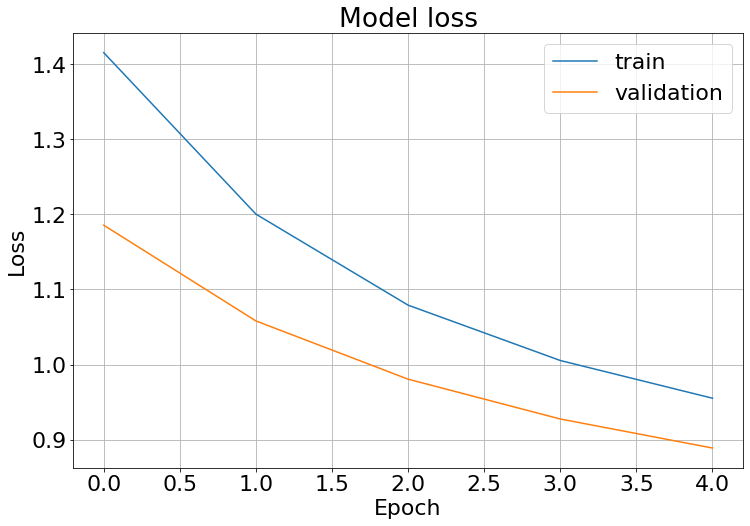

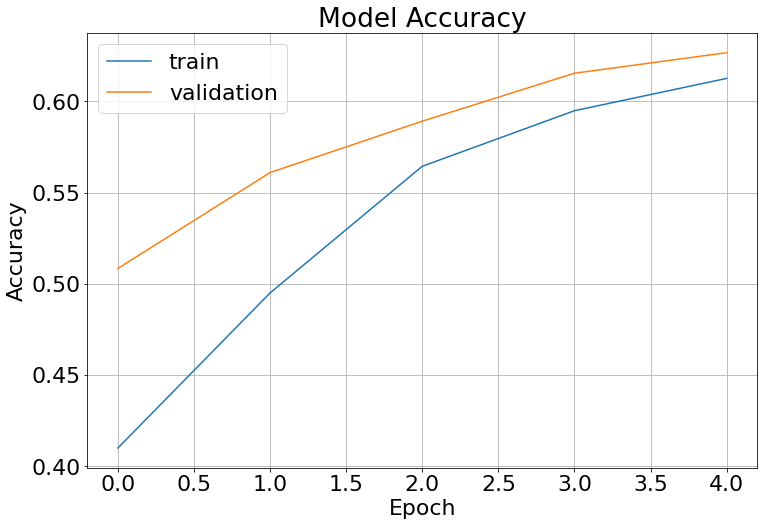

In [ ]:
#Mobile Net with learning rate 0.001 solver = SGD

model_mobilenet = MobileNetModelforStatus(image_shape)
base_learning_rate = 0.001
model_mobilenet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 5
history_mobilenet = model_mobilenet.fit(train_dataset, validation_data=dev_dataset, epochs=initial_epochs)
df_loss_acc = pd.DataFrame(history_mobilenet.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
# df_acc.grid(True)
df_loss.plot(title='Model loss',figsize=(12,8), grid=True).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8), grid=True).set(xlabel='Epoch',ylabel='Accuracy')
scores = model_mobilenet.evaluate(test_dataset, verbose=0)
print(scores)

Custom CNN

In [ ]:
def customModel1():
  # 16 -32-64-64-128
  model = models.Sequential()
  model.add(layers.Conv2D(16, kernel_size = [3,3],activation = 'relu', strides = (3,3),padding= 'same', input_shape=train_images[0].shape))
  model.add(layers.MaxPooling2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))

  model.add(layers.Conv2D(32, kernel_size = [3,3],activation = 'relu', strides = (3,3),padding= 'same', ))
  model.add(layers.MaxPooling2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))

  model.add(layers.Conv2D(64, kernel_size = [5,5],activation = 'relu',padding= 'same', ))
  model.add(layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))

  model.add(layers.Conv2D(64, kernel_size = [5,5],activation = 'relu',padding= 'same', ))
  model.add(layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))

  model.add(layers.Conv2D(128, kernel_size = [7,7],activation = 'relu',padding= 'same', ))
  model.add(layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))

  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))

  model.summary()
  return model

In [ ]:
def customModel2():
  model = models.Sequential()
  model.add(layers.Conv2D(16, kernel_size = [3,3],activation = 'relu', strides = (3,3),padding= 'same', input_shape=train_images[0].shape))
  model.add(layers.MaxPooling2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))

  model.add(layers.Conv2D(32, kernel_size = [3,3],activation = 'relu',padding= 'same', ))
  model.add(layers.MaxPooling2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))

  model.add(layers.Conv2D(64, kernel_size = [5,5],activation = 'relu',padding= 'same', ))
  model.add(layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))

  model.add(layers.Conv2D(128, kernel_size = [5,5],activation = 'relu',padding= 'same', ))
  model.add(layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding= 'same'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))

  model.summary()
  return model

In [ ]:
def plot(history):
  df_loss_acc = pd.DataFrame(history.history)
  df_loss= df_loss_acc[['loss','val_loss']]
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
  df_acc= df_loss_acc[['accuracy','val_accuracy']]
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
  df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
  df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)         

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[0.8715145587921143, 0.6413662433624268]


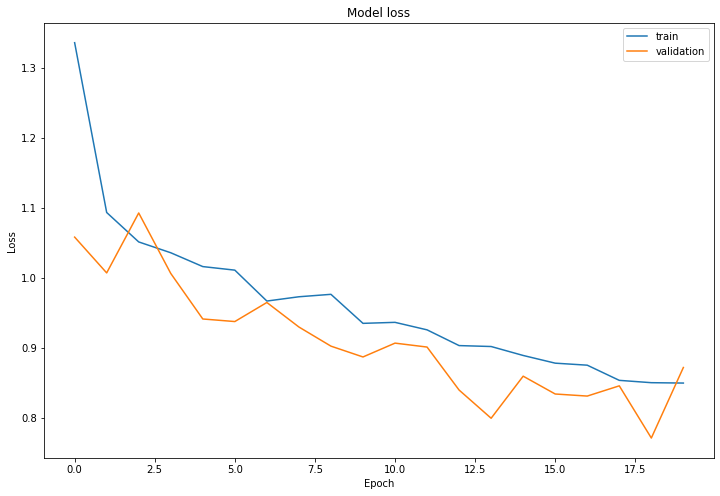

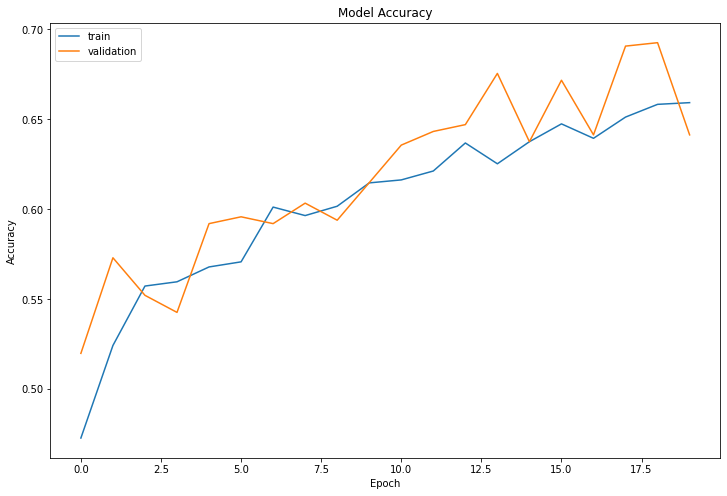

In [ ]:
# model 1 Adam 0.001
model = customModel1()

learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

custom_history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)
plot(custom_history)
scores = model.evaluate(test_dataset, verbose=0)
print(scores)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 86, 86, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 43, 43, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 128)      

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[0.9060441255569458, 0.6129032373428345]


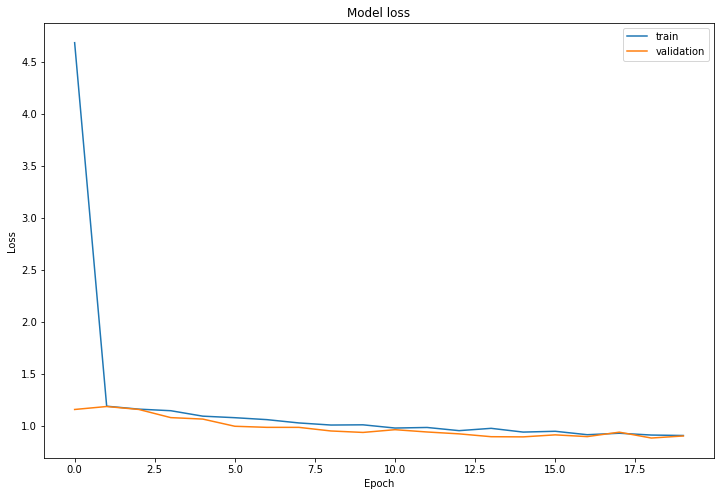

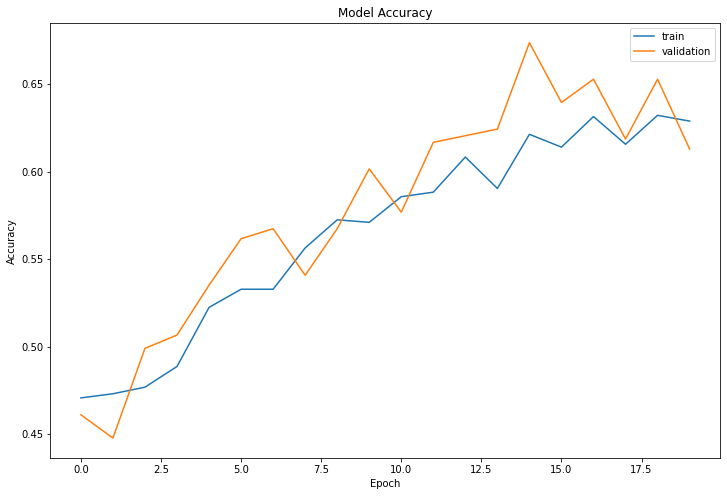

In [ ]:
model = customModel2()
#Adam
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

custom_history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)
plot(custom_history)
scores = model.evaluate(test_dataset, verbose=0)
print(scores)

In [ ]:
#model 1 SGD learning rate 0.001
model = customModel1()

learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

custom_history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)
plot(custom_history)
scores = model.evaluate(test_dataset, verbose=0)
print(scores)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 86, 86, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)         

In [ ]:
#model 1 Adam learning rate 0.01
model = customModel1()

learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

custom_history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)
plot(custom_history)
scores = model.evaluate(test_dataset, verbose=0)
print(scores)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 86, 86, 16)        448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 43, 43, 32)        4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 22, 64)        51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 128)      

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[1.1317543983459473, 0.4914610981941223]


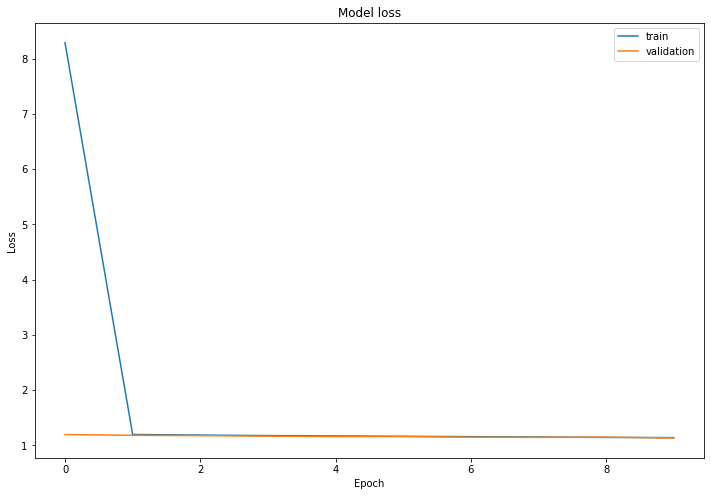

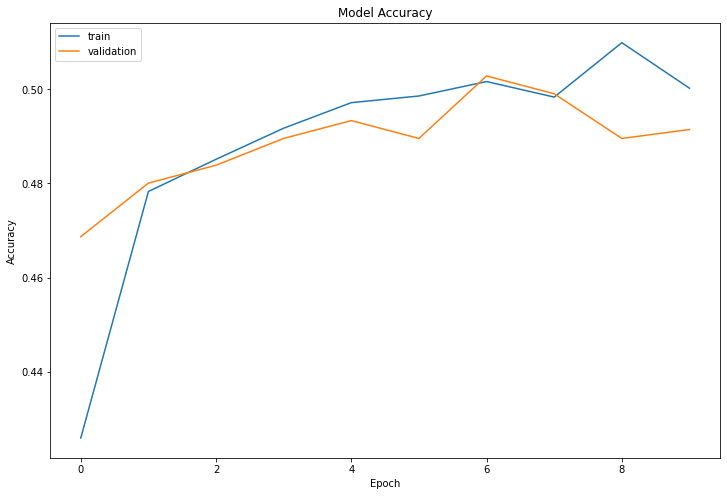

In [ ]:
#model 2 SGD learning rate 0.001
model = customModel2()

learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

custom_history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)
plot(custom_history)
scores = model.evaluate(test_dataset, verbose=0)
print(scores)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 86, 86, 16)        448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 43, 43, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 22, 22, 64)        51264     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 128)      

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[1.192023754119873, 0.47438329458236694]


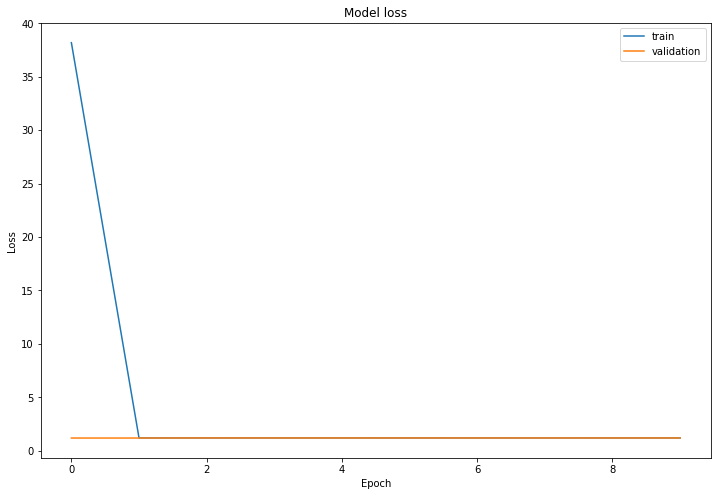

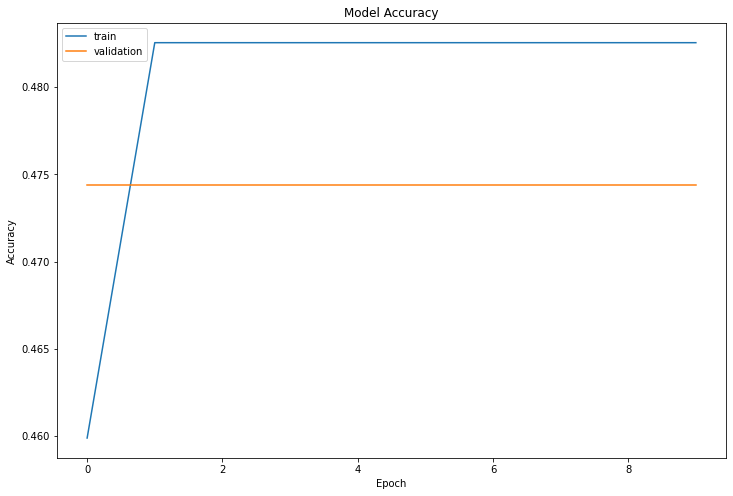

In [ ]:
#model 2 Adam learning rate 0.01
model = customModel2()

learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

custom_history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)
plot(custom_history)
scores = model.evaluate(test_dataset, verbose=0)
print(scores)